#### Import all the required packages

In [2]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [3]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix

In [4]:
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [5]:
## Uncomment for descriptions of shows and episodes (not required for the following analysis)
show_descriptions_aggregated = shows.apply(lambda x: x.show_description.unique()[0])
episode_descriptions_aggregated = shows.apply(lambda x: list(x.episode_description))
descriptions_aggregated = {}
for k,text in enumerate(episode_descriptions_aggregated):
    descriptions_aggregated[show_names[k]] = [show_descriptions_aggregated[k]]+text

In [6]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","game","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","wallstreet","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital","christian","christianity","boardgames",\
                  "boardgame","videogames","videogame","twitch","currency","cryptocurrency","federal","bank",\
                  "blockchain","bitcoin","nyse","nft","import","export","capital","money","exchange","boxing",\
                  "mma","wrestling","excercise","excercises","gym","bodybuilding","body-building","yoga",\
                  "stamina","strength","calories","meditation","physical","healthy","pope","bible","catholic",\
                  "catholicism","testament"]

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

In [7]:
podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [8]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [9]:
health_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("fitness" in val)\
                                                                or ("health" in val)\
                                                                or ("diet" in val)\
                                                                or ("nutrition" in val)\
                                                                or ("healthy" in val)\
                                                                or ("meditation" in val)\
                                                                or ("mental" in val)\
                                                                or ("physical" in val)\
                                                                or ("excercise" in val)\
                                                                or ("calories" in val)\
                                                                or ("gym" in val)\
                                                                or ("bodybuilding" in val)\
                                                                or ("body-building" in val)\
                                                                or ("stamina" in val)\
                                                                or ("strength" in val)\
                                                                or ("excercise" in val)\
                                                                or ("yoga" in val)]

In [10]:
sports_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("sports" in val)\
#                                                             or ("games" in val)\
#                                                             or ("game" in val)\
                                                            or ("videogame" in val)\
                                                            or ("videogames" in val)\
                                                            or ("boardgame" in val)\
                                                            or ("boardgames" in val)\
                                                            or ("xbox" in val)\
                                                            or ("nintendo" in val)\
                                                            or ("twitch" in val)\
                                                            or ("ps4" in val)\
                                                            or ("ps5" in val)\
                                                            or ("playstation" in val)\
                                                            or ("basketball" in val)\
                                                            or ("football" in val)\
                                                            or ("soccer" in val)\
                                                            or ("baseball" in val)\
                                                            or ("boxing" in val)\
                                                            or ("wrestling" in val)\
                                                            or ("mma" in val)\
                                                            or ("tennis" in val)]

In [11]:
religion_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("religion" in val)\
                                                            or ("faith" in val)\
                                                            or ("church" in val)\
                                                            or ("christ" in val)\
                                                            or ("christian" in val)\
                                                            or ("christianity" in val)\
                                                            or ("bible" in val)\
                                                            or ("testament" in val)\
                                                            or ("pope" in val)\
                                                            or ("catholic" in val)\
                                                            or ("catholicism" in val)]

In [12]:
invest_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("market" in val)\
                                                            or ("business" in val)\
                                                            or ("invest" in val)\
                                                            or ("stocks" in val)\
                                                            or ("stock" in val)\
                                                            or ("wallstreet" in val)\
                                                            or ("investing" in val)\
                                                            or ("investment" in val)\
                                                            or ("exchange" in val)\
                                                            or ("nyse" in val)\
                                                            or ("capital" in val)\
                                                            or ("money" in val)\
                                                            or ("currency" in val)\
                                                            or ("cryptocurrency" in val)\
                                                            or ("blockchain" in val)\
                                                            or ("bitcoin" in val)\
                                                            or ("federal" in val)\
                                                            or ("bank" in val)\
                                                            or ("nft" in val)]

In [63]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
sports_cs = []
with open('/home1/sgmark/capstone-project/model/coherence_scores_sports_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        sports_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[3] for x in sports_cs])]

In [64]:
best_hp_setting

(7, (6, 0.9))

#### The individual transcript location

In [15]:
def file_location(show,episode):
    search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
                               + "/" + show[0] \
                               + "/" + show[1] \
                               + "/" + "show_" + show \
                               + "/"
    return search_string

#### load the transcripts

In [16]:
transcripts = {}
for podcast,genre in sports_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('../podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [17]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

# # lemmatization -- do lemmatization for just the verbs
# def get_lemmatized(text):
#     lemmatized = []
#     for phrase in text:
#         sentence=''
#         for word in nlp(phrase):
#             if word.pos_ == "VERB":
#                 #or word.pos_ == "ADJ" or word.pos_ == "ADV":
#                 sentence += ' ' + str(word.lemma_)
#             elif str(word)!='':
#                 sentence += ' ' + str(word)
#         lemmatized.append(sentence.strip())
#     return lemmatized

# def get_named_entities(text):
#     return nlp(text.lower()).ents

# def get_noun_chunks(text):
#     non_stop_noun_chunks = []
#     stops = stopwords.words("english")
#     for word in nlp(text.lower()).noun_chunks:
#         if str(word) not in stops:
#             non_stop_noun_chunks.append(word)
#     return non_stop_noun_chunks

#### tokenize/convert text into words

In [18]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [47]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))

In [48]:
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [49]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)
                 #best_hp_setting[1][0])

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [65]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [66]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_sports_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

In [67]:
%%time
import logging
logging.basicConfig(filename='sports_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 25.6 s, sys: 13.4 ms, total: 25.6 s
Wall time: 25.6 s


In [25]:
top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -0.7116.


In [26]:
cm = CoherenceModel(lda_model, texts = texts, corpus=corpus, coherence='c_npmi')
coherence = cm.get_coherence() 
print(coherence)
for x in cm.get_coherence_per_topic(): print(x)

0.03905895361784011
0.024165728681836945
0.1492834137538285
-0.007463909404059377
0.019001497190662995
0.0020731429351815256
0.03062606430816478
0.05572673785926546


### Visualizing data

In [68]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_html(vis,'sports_uci_npmi.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.029510 -0.091493       1        1  33.423031
0     -0.132049  0.086090       2        1  28.288889
4      0.072957  0.153506       3        1  21.923350
6      0.329735  0.057295       4        1   7.285020
2      0.183351 -0.249251       5        1   5.409826
3     -0.306753 -0.232901       6        1   3.642798
5     -0.117732  0.276755       7        1   0.027086, topic_info=               Term          Freq         Total Category  logprob  loglift
471            card   3805.000000   3805.000000  Default  20.0000  20.0000
113            game  13631.000000  13631.000000  Default  19.0000  19.0000
327            team   6127.000000   6127.000000  Default  18.0000  18.0000
253          player   3220.000000   3220.000000  Default  17.0000  17.0000
311           sport   2230.000000   2230.000000  Default  16.0000  16.0000
...             ...           ...           ...      ...      ...      ...
6322          creek      0.015690      6.465719   Topic7  -9.0769   2.1927
3672        reflect      0.015760      8.561128   Topic7  -9.0724   1.9164
5101     tiebreaker      0.015807     11.645280   Topic7  -9.0695   1.6117
2698  mental_health      0.015906     16.146169   Topic7  -9.0632   1.2912
6316      vegetable      0.015758     16.553745   Topic7  -9.0726   1.2569

[331 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
400       1  0.994756      aaron
7213      3  0.993524  afterbuzz
7         1  0.998026    alabama
7060      6  0.990747     albany
1915      1  0.217216   analytic
...     ...       ...        ...
395       6  0.146178       yard
3628      5  0.966015  youngster
5583      2  0.998491      zelda
4057      1  0.136133       zion
4057      4  0.861039       zion

[708 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 7, 3, 4, 6])

In [29]:
# from pprint import pprint
# pprint(top_topics)

In [54]:
import pickle

pickle.dump(lda_model,open('../model/sports_episodes_lda_model_umass.pkl','wb'))
pickle.dump(dictionary,open('../model/sports_episodes_dictionary_umass.pkl','wb'))
pickle.dump(corpus,open('../model/sports_episodes_corpus_umass.pkl','wb'))

In [4]:
# import pickle

# file = open('../model/sports_episodes_lda_model.pkl','rb')
# lda_model = pickle.load(file)
# file.close()

# file = open('../model/sports_episodes_corpus.pkl','rb')
# corpus = pickle.load(file)
# file.close()

# file = open('../model/sports_episodes_dictionary.pkl','rb')
# dictionary = pickle.load(file)
# file.close()

In [55]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode')], axis=1)

    return result_df

In [56]:
# main_topic_df = pd.read_pickle('../model/sports_topics_main_df.pkl')
main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('sports_topics_main_df_umass.pkl')

In [57]:
main_topic_df.head(3)

,show_filename_prefix,episode_filename_prefix,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode
0,show_04nSDGOhSUfh3yg0Nqvub2,6R0r4pXmbZ2zcUdK3EBTg7,100% Sports,"Episode 1: College football predictions, playo...",5,0.789,"[lady, gentleman, afternoon, detroit, michigan...",defense football game league mean play player ...,42.0138,Ryan Glinski,My cousin and I talk about our favorites to wi...
1,show_6AWE4Ng9VEEaNKDAMda63k,6cSy8D9tqvT0KWXCujG5Fe,2 Dudes and a NES: A Nintendo Podcast,Gremlins 2: The New Batch,3,0.547,"[nose, gamer, youtube, atari, game, game, prid...",character game level mario mean nintendo pokem...,84.98928333333333,Bit Brothers Network,What late night snack will the Dudes rate this...
2,show_63EPfkKiQTuAZFvGK8BgQY,3v2TS17vDgo1jIrvNfkuIv,605 Sports Under Review with Coach DeBeer,SDHSAA Executive Producer Dan Swartos,0,0.518,"[thank, court, coach, tobira, radio, station, ...",basketball card coach game high number player ...,36.81785,Brad D DeBeer,Dr. Dan Swartos and I discuss a variety of top...


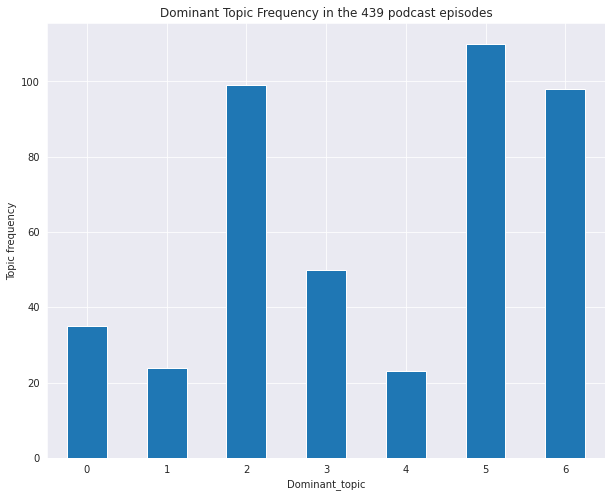

In [34]:
plt.figure(figsize=(10,8))
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Podcast_name'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} podcast episodes'.format(len(texts)),
        ylabel='Topic frequency'); 

In [35]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1)])
    
representatives

,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode
74,MMA All Day,2019 we here dawg,0,0.856,"[illuminati, button, mike, parrilla, swan, hap...",coach different fight fighter hand head level ...,72.63743333333333,MMA AllDay,"This Style bender hype, this cyborg situation,..."
304,Straight-Up Sports,Missouri 8-Man Recap,1,0.909,"[straight, sport, missouri, football, number, ...",city conference county game livingston north n...,18.51675,Devin Lynn Albertson,Enjoy and share!
169,Nintendo Cartridge Society,Link’s Awakening Music (News from 10/1/19),2,1.000,"[nintendo, cartridge, society, game, brain, pa...",character game level mario mean nintendo pokem...,47.86831666666666,Campfire Media,Patrick and Mark listen to some of the work in...
416,X-Pac 12360 - A Wrestling Podcast,Remembering Owen Hart & Double or Nothing prev...,3,0.894,"[xbox, text, right, body, anyways, distracted,...",different huge love match mean night person re...,79.58716666666666,AfterBuzz TV,This week Sean and the crew talk about Double...
48,Everything DFS Sports,Week 1 Full Slate Breakdown,4,0.992,"[place, right, phone, computer, phone, creatio...",ball defense game mean number play player quar...,57.76621666666666,SlabOf Meatloaf,Breakdown of the entire week 1 NFL slate. If y...
238,Sports Card Investor,How to Find Great Deals in Unexpected Ways,5,1.000,"[jeff, wilson, tech, company, night, sport, pr...",card different game league number player price...,30.26808333333333,Sports Card Investor,"With a little creativity, you can find some am..."
15,Best Sports Blogs,Best Sports Blogs: The Best Sport Sites to Read,6,0.995,"[sport, blog, sport, sport, long, interest, fo...",coach football game home mean play school seas...,2.5317,viven irem,Sport is one of those things that you’ll have ...


In [47]:
representatives.iloc[0]['Description of the episode']

'This Style bender hype, this cyborg situation, etc etc....fuck hype jobs '

In [48]:
representatives.iloc[0]['Keywords']

'coach different fight fighter hand head level mean person prison'

In [ ]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [36]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [37]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=6), Output()), _dom_classes=('widget-interac…

In [38]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))

Indices of top words: 
{768, 132, 1160, 778, 650, 267, 139, 912, 913, 916, 789, 6175, 294, 296, 3371, 172, 814, 175, 431, 49, 313, 186, 4155, 59, 190, 320, 195, 329, 74, 78, 1359, 593, 337, 474, 219, 736, 3426, 738, 488, 107, 3952, 114, 501, 634, 2811, 253, 254}



In [39]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [40]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

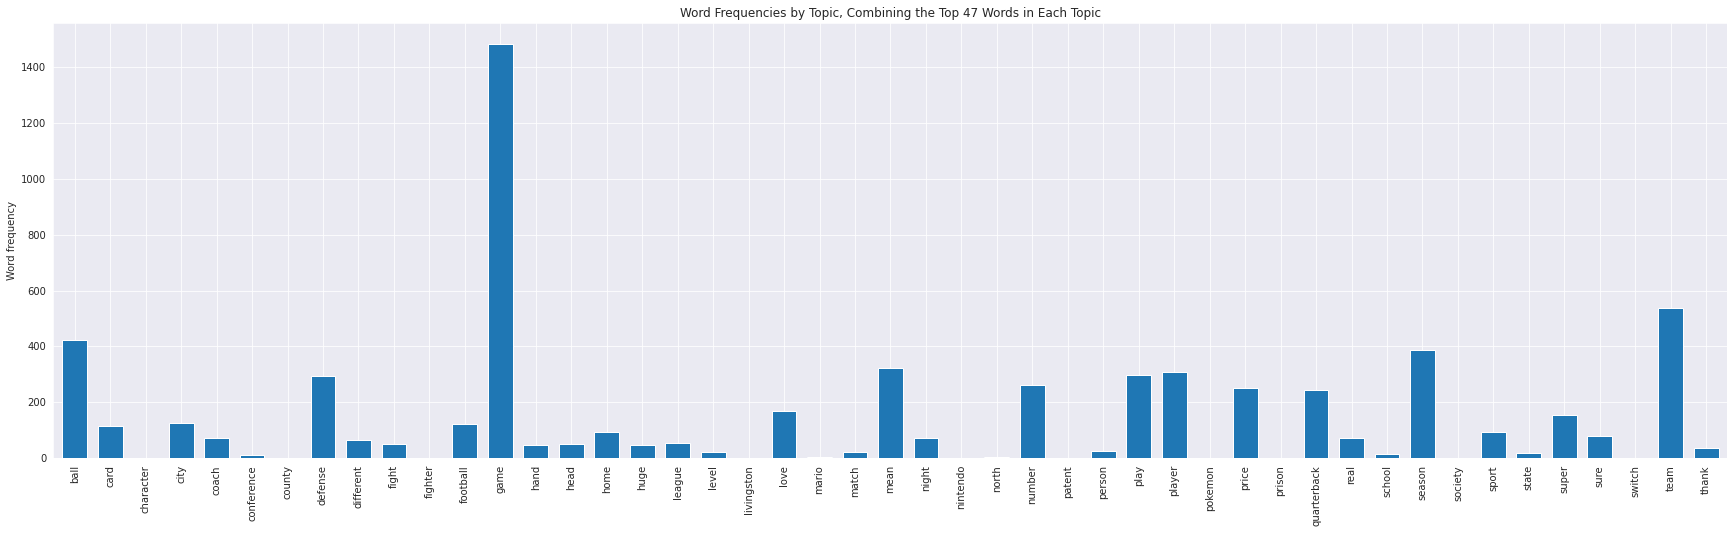

In [54]:
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(4)

clusterwise_words_dist.sum()[:-1].transpose().\
         plot.bar(figsize=(30, 8), width=0.7).\
         set(ylabel='Word frequency', 
         title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(len(lda_top_words_index)));

In [42]:
[dictionary[k] for k,x in lda_model.get_topic_terms(2)]

['game',
 'nintendo',
 'mario',
 'character',
 'super',
 'mean',
 'switch',
 'pokemon',
 'level',
 'society']

In [43]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(top_topics)}

In [44]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=best_hp_setting[0]-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=6), Output()), _dom_classes=('widget-interac…